In [12]:
from IPython.display import display,HTML
import warnings
warnings.filterwarnings(action='ignore')

#데이터 전처리
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
#기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score,recall_score,precision_score,mean_squared_error,confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from datetime import datetime
from io import StringIO
matplotlib.rcParams['axes.unicode_minus'] = False
#한글 폰트 설정
plt.rc('font',family ='Malgun Gothic')
import matplotlib.dates as mdates


from changefinder import ChangeFinder


               지점  평균 풍속(m/s)  평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  평균 수온(°C)  \
일시                                                                           
1998-04-07  22104         NaN        NaN         NaN        NaN        NaN   
1998-04-08  22104         NaN        NaN         NaN        NaN        NaN   
1998-04-09  22104         NaN        NaN         NaN        NaN        NaN   
1998-04-10  22104         NaN        NaN         NaN        NaN        NaN   
1998-05-07  22104         NaN        NaN         NaN        NaN        NaN   
...           ...         ...        ...         ...        ...        ...   
2023-05-13  22104         4.1     1013.5        95.0       15.7       16.1   
2023-05-14  22104         3.9     1009.6        94.0       16.5       16.5   
2023-05-15  22104         3.2     1010.0        96.0       17.2       16.7   
2023-05-16  22104         6.7     1012.7        99.0       17.2       16.6   
2023-05-17  22104         4.7     1015.4        99.0       17.8 

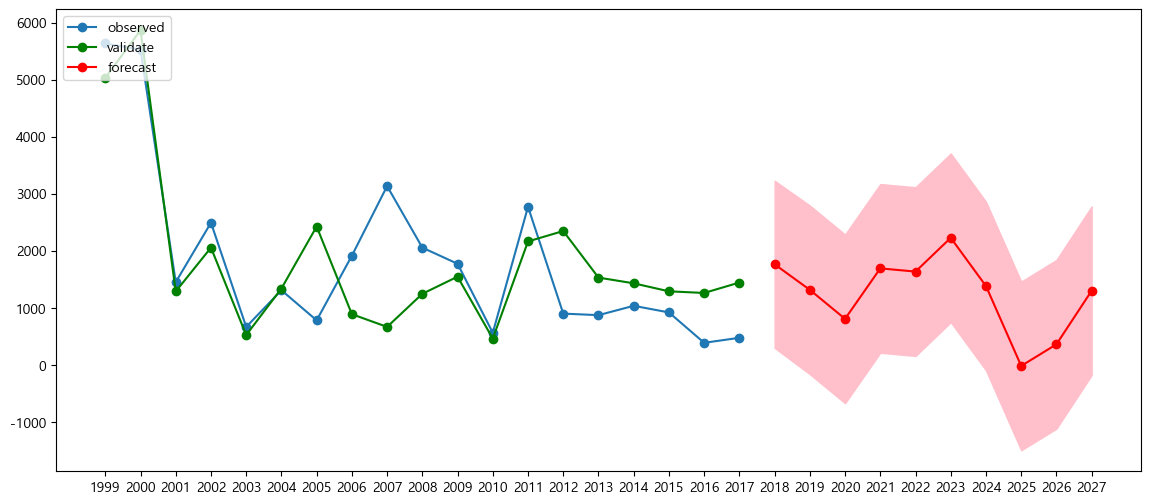

                                      SARIMAX Results                                       
Dep. Variable:                                   부산   No. Observations:                   19
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                -154.981
Date:                              Wed, 31 May 2023   AIC                            333.962
Time:                                      13:17:16   BIC                            345.295
Sample:                                  12-31-1999   HQIC                           335.880
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)    900.5338   4050.458      0.222      0.824   -7038.217    8839.285
평균기압(hPa)      1

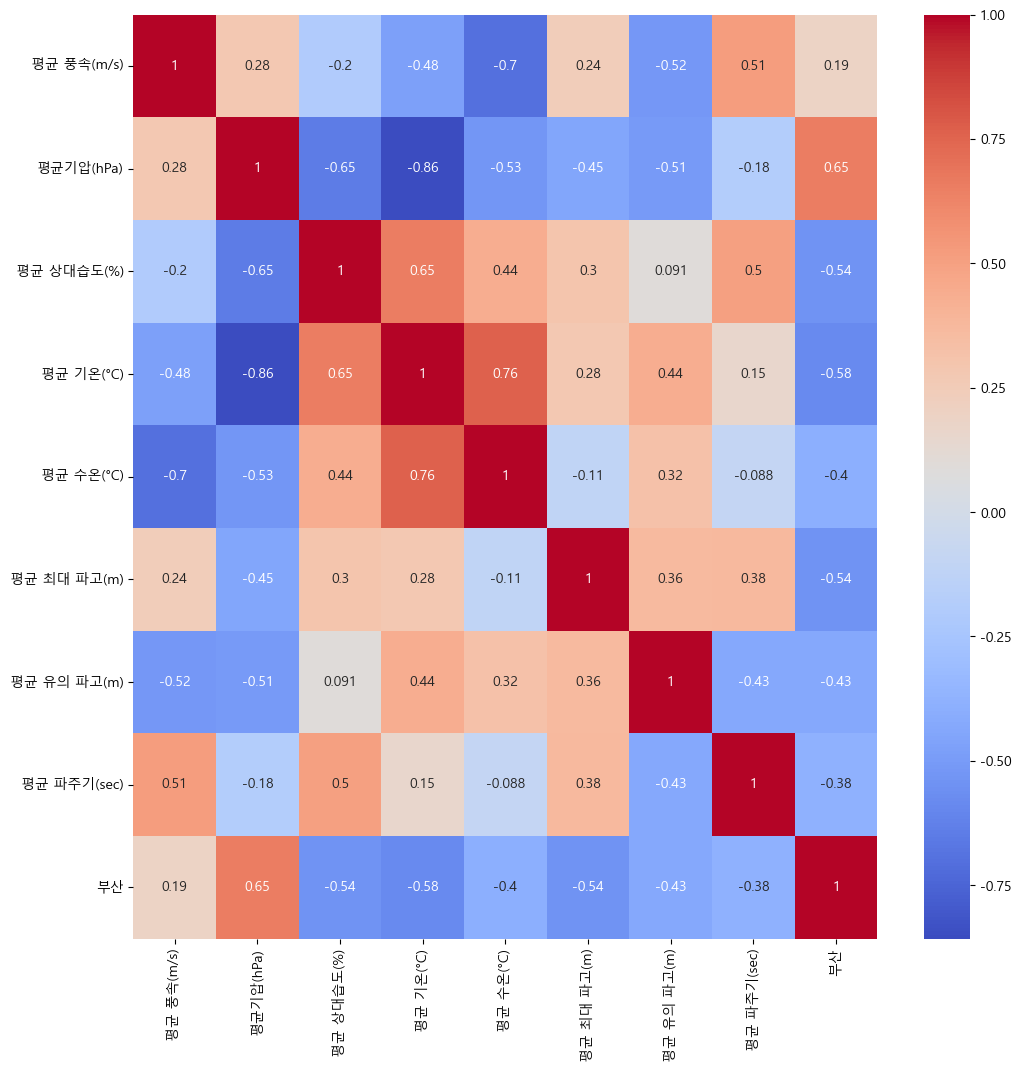

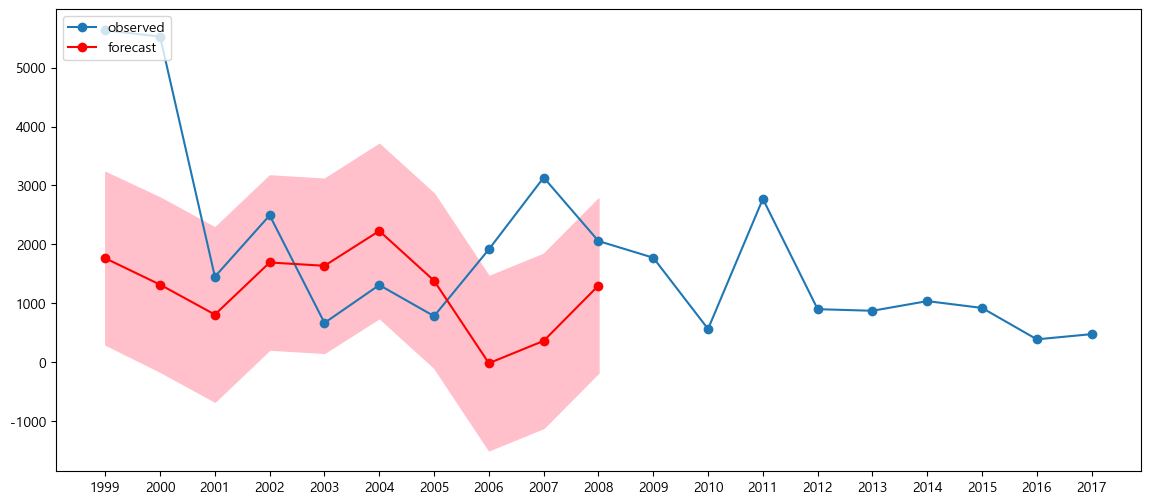

                                      SARIMAX Results                                       
Dep. Variable:                                   부산   No. Observations:                   19
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                -154.981
Date:                              Wed, 31 May 2023   AIC                            333.962
Time:                                      13:17:17   BIC                            345.295
Sample:                                  12-31-1999   HQIC                           335.880
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)    900.5338   4050.458      0.222      0.824   -7038.217    8839.285
평균기압(hPa)      1

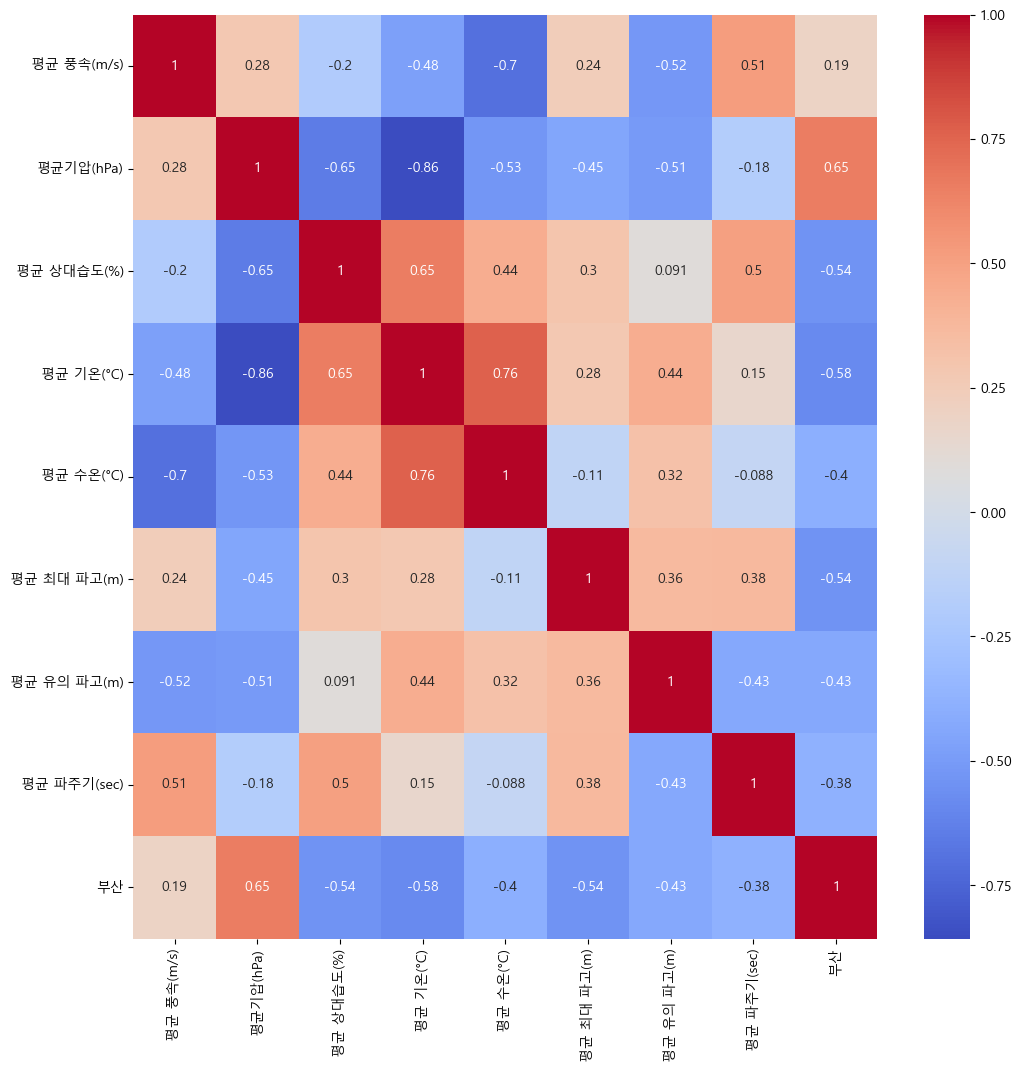

In [13]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data1 = pd.read_csv('data/참조기어획량(year,ton).csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # Date를 인덱스로
data.index = pd.to_datetime(data.index)
print(data)
print(data1)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('Y').mean()

data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

print(data)


# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '1999-01-03'
end_date = '2018-01-07'
data = data.loc[start_date:end_date]
# data1 = data1.loc[start_date:end_date]
data1 = data1.loc[(data1['일시'] >= start_date) & (data1['일시'] <= end_date)]
data1 = data1.set_index('일시')  # 다시 인덱스로 설정

print(data)
print(data1)

data = pd.concat([data, data1], axis=1)
print('data:',data)
data.to_csv('data/data어획_test.csv', index=False)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)','부산']]

# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['부산'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
validate_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
validate = results.get_forecast(steps=validate_steps, exog=exog[-validate_steps:])
validate_conf_int = validate.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
print('validate_index',validate_index)

validate_index_timestamp = validate_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate.predicted_mean.index = validate_index
validate_conf_int.index = validate_index
print('validate.predicted_mean',validate.predicted_mean)
# 
# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(data.index).strftime('%Y'), data['부산'], label='observed', marker='o', linestyle='-')
plt.plot(validate_index.strftime('%Y'), validate.predicted_mean, label='validate', color='g', marker='o', linestyle='-')

forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
forecast_index = pd.period_range(start='2018-05-19', periods=forecast_steps, freq='y')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
plt.plot(forecast_index.strftime('%Y'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index.strftime('%Y'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['부산'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast_index = pd.period_range(start='1999-05-19', periods=forecast_steps, freq='y')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index


# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(data.index).strftime('%Y'), data['부산'], label='observed', marker='o', linestyle='-')
plt.plot(forecast_index.strftime('%Y'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index.strftime('%Y'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['부산'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))



# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast.predicted_mean.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)

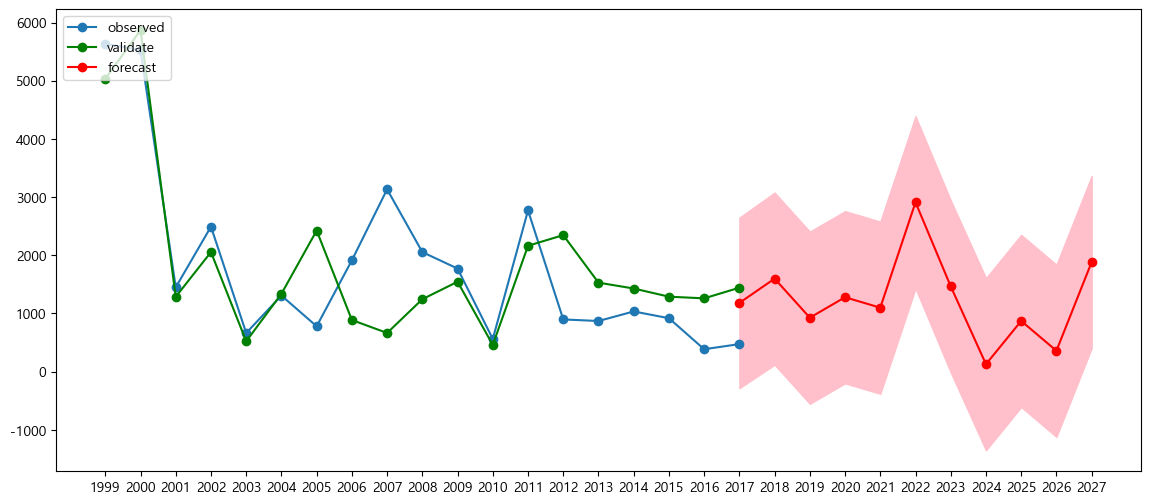

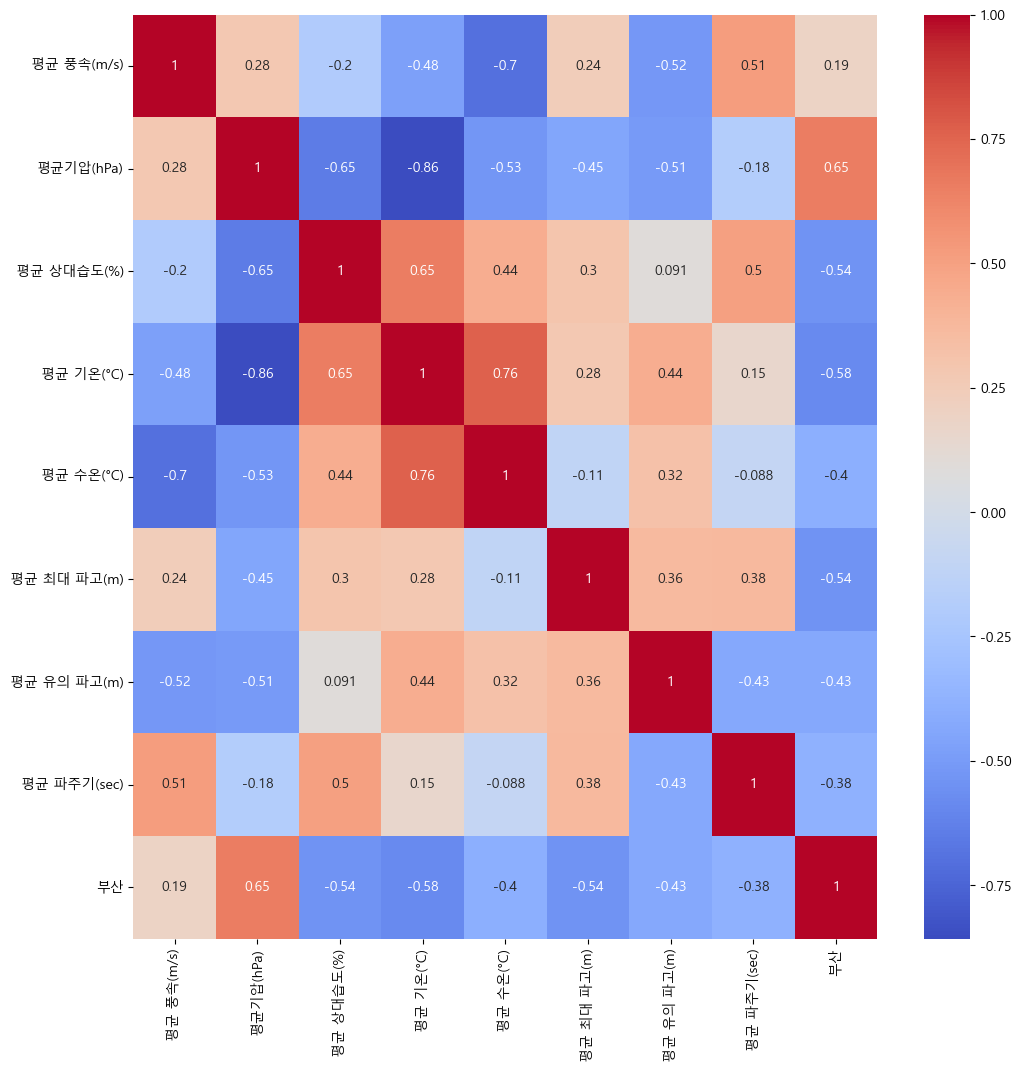

,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 수온(°C),평균 최대 파고(m),평균 유의 파고(m),평균 파주기(sec),부산
일시,,,,,,,,,
1999-12-31,5.992509,1016.154307,69.519685,15.284064,18.648864,1.367704,0.439063,1.912044,5635
2000-12-31,6.405650,1019.314948,60.989691,9.715979,15.453608,1.509474,0.497906,1.568844,5527
2001-12-31,6.594154,1016.309568,72.735849,14.704658,17.195679,1.637736,0.545912,17.445062,1450
2002-12-31,6.639474,1016.022930,73.286624,13.792675,15.526667,1.727852,0.572449,16.354967,2492
2003-12-31,6.425298,1015.611976,73.248503,14.975449,18.642202,1.658491,0.555280,16.907524,665
2004-12-31,6.109581,1015.954142,72.115385,16.614201,19.077219,1.646795,0.553526,18.286129,1308
2005-12-31,6.327070,1015.644409,70.439490,15.100955,18.509177,1.708532,0.572014,8.481100,780
2006-12-31,6.312460,1015.694410,72.121406,15.527796,16.427273,1.772897,0.729595,9.655901,1914
2007-12-31,5.999169,1015.299449,71.650138,15.505263,18.611080,1.734160,1.058726,6.002216,3134


In [14]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data1 = pd.read_csv('data/참조기어획량(year,ton).csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # Date를 인덱스로
data.index = pd.to_datetime(data.index)
# print(data)
# print(data1)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('Y').mean()

data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

# print(data)


# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '1999-01-03'
end_date = '2018-01-07'
data = data.loc[start_date:end_date]
# data1 = data1.loc[start_date:end_date]
data1 = data1.loc[(data1['일시'] >= start_date) & (data1['일시'] <= end_date)]
data1 = data1.set_index('일시')  # 다시 인덱스로 설정

# print(data)
# print(data1)

data = pd.concat([data, data1], axis=1)
# print('data:',data)
data.to_csv('data/data어획_test.csv', index=False)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)','부산']]

# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['부산'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
validate_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
validate = results.get_forecast(steps=validate_steps, exog=exog[-validate_steps:])
validate_conf_int = validate.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
# print('validate_index',validate_index)

validate_index_timestamp = validate_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate.predicted_mean.index = validate_index
validate_conf_int.index = validate_index
# print('validate.predicted_mean',validate.predicted_mean)
# 
# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(data.index).strftime('%Y'), data['부산'], label='observed', marker='o', linestyle='-')
plt.plot(validate_index.strftime('%Y'), validate.predicted_mean, label='validate', color='g', marker='o', linestyle='-')

forecast_steps = 11
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
forecast_index = pd.period_range(start='2017-05-19', periods=forecast_steps, freq='y')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
plt.plot(forecast_index.strftime('%Y'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index.strftime('%Y'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['부산'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
# print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

forecast.predicted_mean.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)
data

In [15]:
import pymysql
from sqlalchemy import create_engine, types
# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'fish'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
validate.predicted_mean.index = validate_index
validate.predicted_mean = validate.predicted_mean.reset_index()
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, validate.predicted_mean, forecast.predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['charmrealbs', 'charmoalbs', 'charmforebs', 'charmforeconfbs']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float(), '부산': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

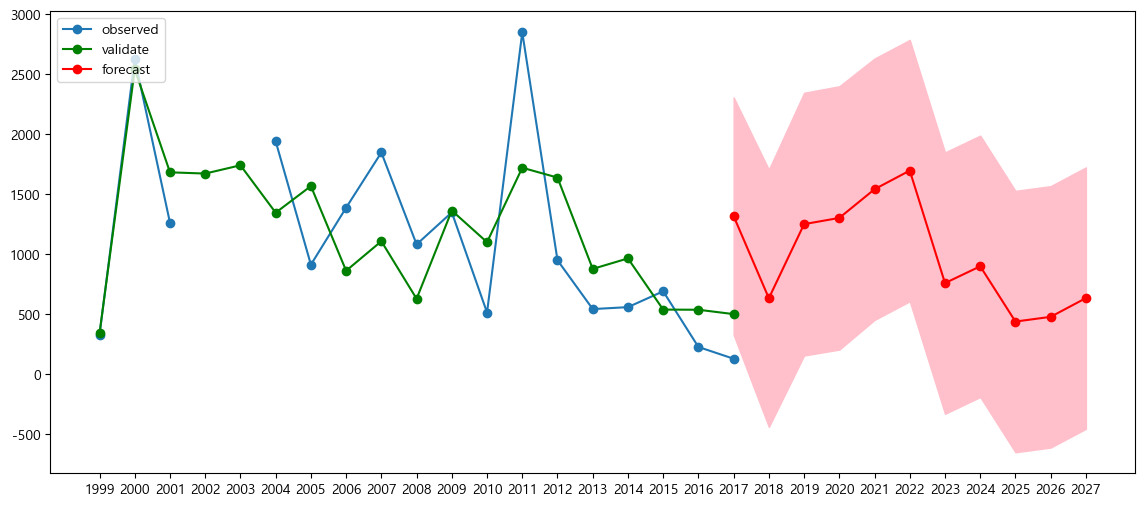

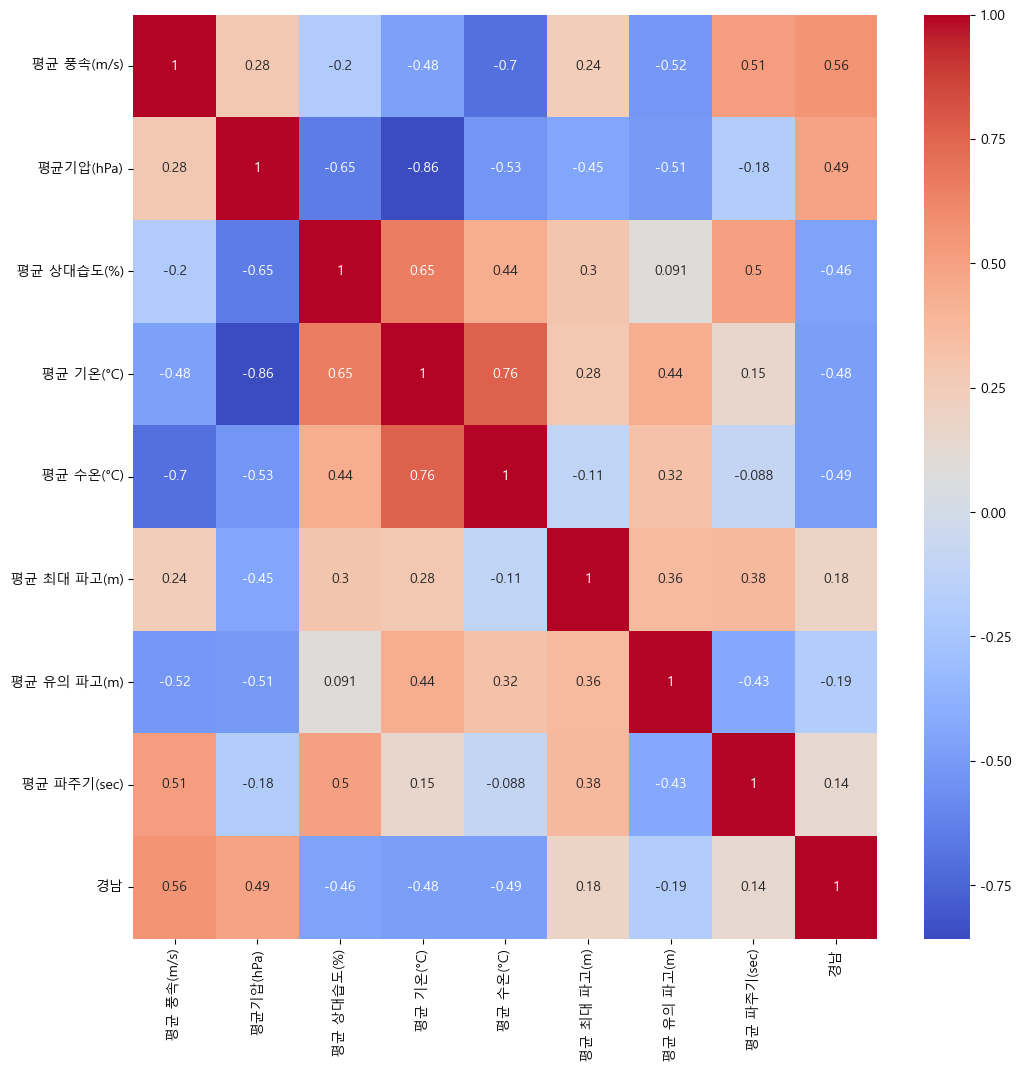

,lower 경남,upper 경남
2017-12-31,328.744764,2308.746694
2018-12-31,-438.600224,1707.010363
2019-12-31,156.846745,2346.784823
2020-12-31,206.397033,2401.067943
2021-12-31,453.416741,2632.197480
2022-12-31,608.797657,2787.723031
2023-12-31,-329.061945,1849.888635
2024-12-31,-188.977715,1989.977258
2025-12-31,-649.630202,1529.325535
2026-12-31,-610.213227,1568.742636


In [16]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230518거제해양데이터.csv', parse_dates=True, encoding='utf-8')
data1 = pd.read_csv('data/참조기어획량(year,ton).csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # Date를 인덱스로
data.index = pd.to_datetime(data.index)
# print(data)
# print(data1)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('Y').mean()

data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

# print(data)


# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '1999-01-03'
end_date = '2018-01-07'
data = data.loc[start_date:end_date]
# data1 = data1.loc[start_date:end_date]
data1 = data1.loc[(data1['일시'] >= start_date) & (data1['일시'] <= end_date)]
data1 = data1.set_index('일시')  # 다시 인덱스로 설정

# print(data)
# print(data1)

data = pd.concat([data, data1], axis=1)
# print('data:',data)
data.to_csv('data/data어획_test.csv', index=False)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)','경남']]

# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['경남'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
validate_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
validate = results.get_forecast(steps=validate_steps, exog=exog[-validate_steps:])
validate_conf_int = validate.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
# print('validate_index',validate_index)

validate_index_timestamp = validate_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate.predicted_mean.index = validate_index
validate_conf_int.index = validate_index
# print('validate.predicted_mean',validate.predicted_mean)
# 
# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(data.index).strftime('%Y'), data['경남'], label='observed', marker='o', linestyle='-')
plt.plot(validate_index.strftime('%Y'), validate.predicted_mean, label='validate', color='g', marker='o', linestyle='-')

forecast_steps = 11
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
forecast_index = pd.period_range(start='2017-05-19', periods=forecast_steps, freq='y')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
plt.plot(forecast_index.strftime('%Y'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index.strftime('%Y'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['경남'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)

# 예측 오차 출력
# print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

y_pred.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)
forecast_conf_int

In [17]:
import pymysql
from sqlalchemy import create_engine, types

# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'fish'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
validate.predicted_mean.index = validate_index
validate.predicted_mean = validate.predicted_mean.reset_index()
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, validate.predicted_mean, forecast.predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['charmrealkn', 'charmvalkn', 'charmforekn', 'charmforeconfkn']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float(), '경남': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

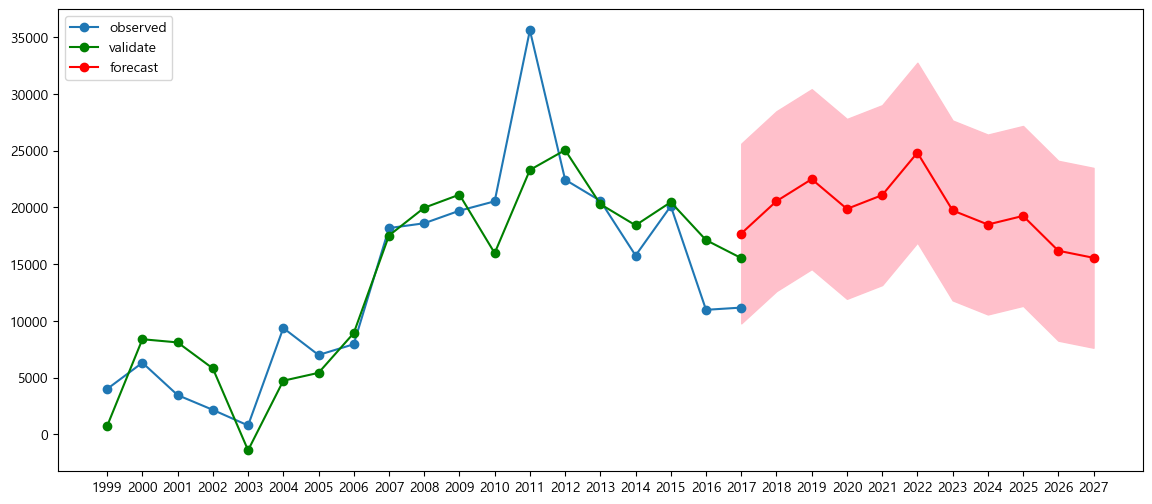

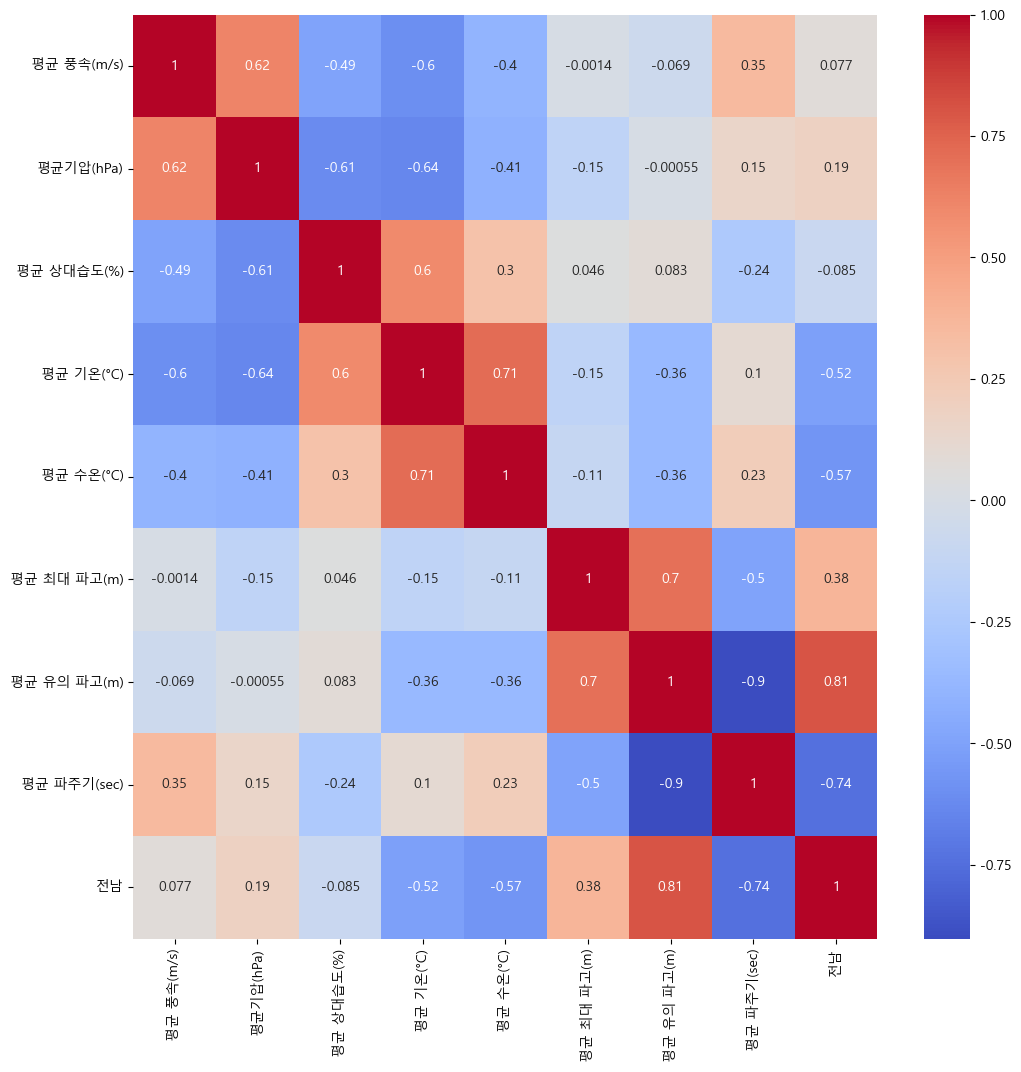

,lower 전남,upper 전남
2017-12-31,9775.779305,25615.659157
2018-12-31,12621.442410,28475.321054
2019-12-31,14559.971157,30413.874545
2020-12-31,11939.067355,27792.970787
2021-12-31,13151.754645,29005.658076
2022-12-31,16894.076261,32747.979693
2023-12-31,11802.682959,27656.586390
2024-12-31,10561.258074,26415.161505
2025-12-31,11320.555737,27174.459168
2026-12-31,8250.060457,24103.963888


In [19]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230519거문도해양데이터.csv', parse_dates=True, encoding='utf-8')
data1 = pd.read_csv('data/참조기어획량(year,ton).csv', parse_dates=True, encoding='utf-8')
data=data.set_index('일시') # Date를 인덱스로
data.index = pd.to_datetime(data.index)
# print(data)
# print(data1)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('Y').mean()

data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

# print(data)


# 특정 기간의 'start_date'과 'end_date' 열 선택
start_date = '1999-01-03'
end_date = '2018-01-07'
data = data.loc[start_date:end_date]
# data1 = data1.loc[start_date:end_date]
data1 = data1.loc[(data1['일시'] >= start_date) & (data1['일시'] <= end_date)]
data1 = data1.set_index('일시')  # 다시 인덱스로 설정

# print(data)
# print(data1)

data = pd.concat([data, data1], axis=1)
# print('data:',data)
data.to_csv('data/data어획_test.csv', index=False)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)','전남']]

# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
# print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['전남'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
validate_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
validate = results.get_forecast(steps=validate_steps, exog=exog[-validate_steps:])
validate_conf_int = validate.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
# print('validate_index',validate_index)

validate_index_timestamp = validate_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
validate.predicted_mean.index = validate_index
validate_conf_int.index = validate_index
# print('validate.predicted_mean',validate.predicted_mean)
# 
# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(data.index).strftime('%Y'), data['전남'], label='observed', marker='o', linestyle='-')
plt.plot(validate_index.strftime('%Y'), validate.predicted_mean, label='validate', color='g', marker='o', linestyle='-')

forecast_steps = 11
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
forecast_index = pd.period_range(start='2017-05-19', periods=forecast_steps, freq='y')
forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
plt.plot(forecast_index.strftime('%Y'), forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index.strftime('%Y'), forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

# print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['전남'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# print(y_pred)

# 예측 오차 출력
# print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

y_pred.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)
forecast_conf_int

In [20]:
import pymysql
from sqlalchemy import create_engine, types

# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'fish'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
validate_index = pd.period_range(start='1999-05-19', periods=validate_steps, freq='y')
validate.predicted_mean.index = validate_index
validate.predicted_mean = validate.predicted_mean.reset_index()
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, validate.predicted_mean, forecast.predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['charmrealjn', 'charmvaljn', 'charmforejn', 'charmforeconfjn']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float(), '전남': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()